In [9]:
import numpy as np
from matplotlib import pyplot as plt

# Prepare some data
def foo(x):
    return x * np.sin(x) + 0.2 * x
#     return x ** 2

N = 16
X = np.concatenate(
    [np.random.uniform(low = -2, high = -0.5, size = (N // 8 * 5,)),
    np.random.uniform(low = 1, high = 1.5, size = (N // 8 * 3,))])
# X = np.random.uniform(low = -2.6, high = 2.6, size = (N,))
Y = foo(X)

X_GT = np.linspace(-3, 3, num = 256)
Y_GT = foo(X_GT)

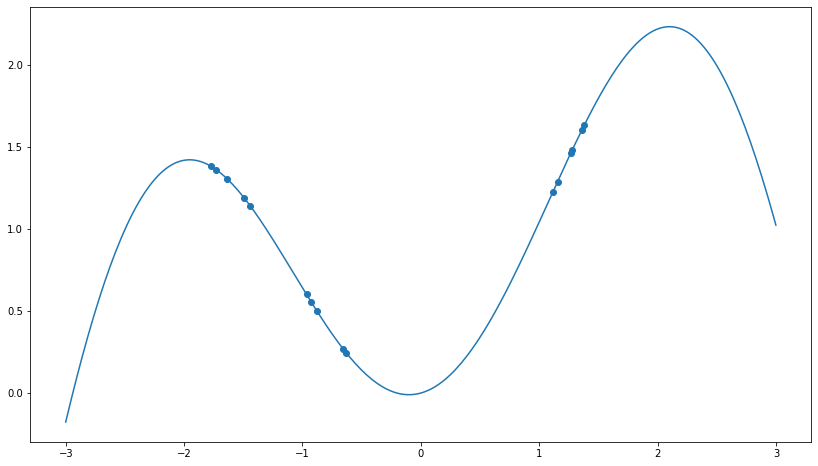

In [10]:
fig = plt.figure(figsize = (14, 8))
plt.scatter(X, Y)
plt.plot(X_GT, Y_GT)
plt.show()

In [11]:
import torch
from torch import nn

input_dim = 1
hidden_dim = 1024
output_dim = 1

nonlin = nn.ReLU()

Y_mean_all = []
N_trials = 8

for trials in range(N_trials):
    
    print("Trial %d" % trials)
    
    net = nn.Sequential(
        nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nonlin,
            nn.Linear(hidden_dim, hidden_dim),
        ),
        nonlin,
    #     nn.Dropout(0.5),
        nn.Linear(hidden_dim, output_dim)
    )

    # optim = torch.optim.SGD(net.parameters(), lr=1e-4, weight_decay = 1e-3)
    optim = torch.optim.Adam(net.parameters(), lr=1e-3)
    # print(list(net.parameters()))

    net = net.cuda()
    Xs = torch.FloatTensor(X).cuda().view(-1, 1)
    Ys = torch.FloatTensor(Y).cuda().view(-1, 1)

    # lossFn = nn.MSELoss()
    lossFn = nn.L1Loss()

    net.train()

    steps = 1000
    for i in range(steps):
        pred = net(Xs)
        loss = lossFn(pred, Ys)
        optim.zero_grad()
        loss.backward()
        optim.step()

#         if i % (steps//10) == (steps // 10) - 1:
#             print("%d: %f" % (i + 1, loss))

    net.eval()

    # Random dropout samplings
    Y_pred = net(Xs).detach().cpu().squeeze()

    Y_GT_pred = []
    N_samples = 20
    for i in range(N_samples):
        ygp = net[0](torch.FloatTensor(X_GT).cuda().view(-1, 1))
        ygp = net[1](ygp)
        ygp = ygp * torch.randint(2, size = (ygp.shape[-1],), device = ygp.device).unsqueeze(0) * 2
        ygp = net[-1](ygp)
        Y_GT_pred.append(ygp.detach().cpu().squeeze())

    # Std
    ygp = net[0](torch.FloatTensor(X_GT).cuda().view(-1, 1))
    ygp = net[1](ygp)
    Y_std = (ygp.unsqueeze(1) * net[-1].weight.unsqueeze(0)).squeeze().std(dim = -1).detach().cpu()
    Y_mean = net(torch.FloatTensor(X_GT).cuda().view(-1, 1)).detach().cpu()
    
    Y_mean_all.append(Y_mean)

print(Y_pred)

Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
tensor([0.4963, 0.5956, 1.3554, 1.1866, 0.5527, 0.2507, 1.2966, 0.2599, 1.3839,
        1.1349, 1.2163, 1.4454, 1.5841, 1.2768, 1.6152, 1.4646])


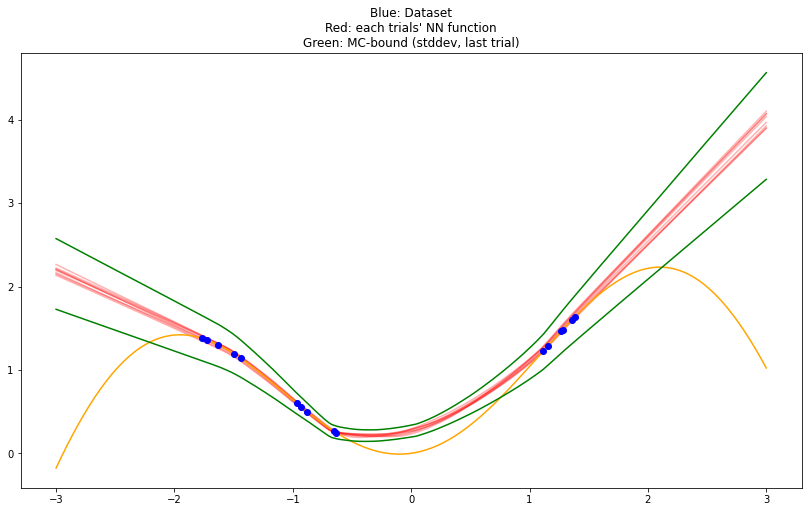

In [20]:
import math

fig = plt.figure(figsize = (14, 8))

# plt.scatter(X, Y_pred, c = 'blue')

for i in range(N_samples):
#     plt.plot(X_GT, Y_GT_pred[i], c = 'blue', alpha = 0.15)
    pass

for i in range(N_trials):
    plt.plot(X_GT, Y_mean_all[i], c = 'red', alpha = 0.3)
    pass

plt.plot(X_GT, Y_GT, c = 'orange')
plt.scatter(X, Y, c = 'blue', alpha = 1, zorder = 100)

# plt.plot(X_GT, Y_mean[:, 0], c = 'blue')
plt.plot(X_GT, Y_mean[:, 0] + math.sqrt(hidden_dim) * Y_std.numpy(), c = 'green')
plt.plot(X_GT, Y_mean[:, 0] - math.sqrt(hidden_dim) * Y_std.numpy(), c = 'green')

# plt.title("Blue: NN (last trial)\nOrange: GT\nRed: each trials\nGreen: MC-stddev (last trial)")
plt.title("Blue: Dataset\nRed: each trials' NN function\nGreen: MC-bound (stddev, last trial)")

plt.show()